In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [17]:
import pdb
import math
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
np.seterr(all='raise')
special.seterr(all='raise')
warpSize = 32
blockSize = 1024
from patch_geo_func import *

In [3]:
den_area = 850 # mm^2 O'Kusky 1982 for the neuronal density we use later  
# exp. measurement 
darea = lambda E: 140*(0.78+E)**(-2.2) # Van Essen 1984 Vision Research "standard" map, 5232x1024
area_slice = lambda E: np.pi*E*darea(E)
# model fit
a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
s1 = 0.76
s2 = 0.1821
model_block = lambda p, e: model_block_ep(e,p,k,a,b,s1,s2)

In [26]:
# total v1 size
r = integrate.quad(area_slice,0,90)
v1_size_exp = r[0]
r = integrate.dblquad(model_block,0,90,-pi/2,pi/2)
v1_size_model = r[0]
display(Latex(rf'Size of V1 = {v1_size_exp:.3f} $mm^2$ (exp.) ~ {v1_size_model:.3f} $mm^2$ (model) ({v1_size_model*100/v1_size_exp:.3f}%)'))
ecc = 2.0
r = integrate.quad(area_slice,0,ecc)
area_exp = r[0]
r = integrate.dblquad(model_block,0,ecc,-np.pi/2,np.pi/2)
area_model = r[0]
display(Latex(rf'A patch of v1 from eccentricity {0} to {ecc} degree yields {area_exp:.3f}  $mm^2$ (exp.) ~ {area_model:.3f}  $mm^2$ (model) ({area_model*100/area_exp:.3f}%)'))
model_ratio = den_area/v1_size_model

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [31]:
print('O''Kusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea')
print('##### L4 #####')
surface_den_L4Cbeta = 30000*model_ratio # per mm^2
display(Latex(rf'Rescale density 30000 per $mm^2$ in O\'Kusky 1982 to {surface_den_L4Cbeta:.3f} per $mm^2$ to keep constant number of neurons'))
assert(30000*den_area == surface_den_L4Cbeta*v1_size_model)
_n_L4Cbeta = area_model*surface_den_L4Cbeta # 32^4 * 10 ~ 10.4 million
n_L4Cbeta = int((_n_L4Cbeta+blockSize-1)//blockSize*blockSize)
nblock_L4Cbeta = n_L4Cbeta//blockSize
block_area_L4Cbeta = area_model/nblock_L4Cbeta
L4_area = area_model
print(f'Rounding number of neurons in L4Cbeta from {_n_L4Cbeta:.3f} to {n_L4Cbeta} = {nblock_L4Cbeta} x {blockSize}')
display(Latex(rf'area per block = {block_area_L4Cbeta:.3f} $mm^2$'))
display(Latex(rf'model density = {n_L4Cbeta/L4_area:.3f} per $mm^2$\n'))
print('##### L2/3 #####')
surface_den_L23 = 18000*model_ratio # per mm^2
display(Latex(rf'Rescale density 18000 per $mm^2$ in O\'Kusky 1982 to {surface_den_L23:.3f} per $mm^2$ to keep constant number of neurons'))
_n_L23 = area_model*surface_den_L23
n_L23 = int((_n_L23+blockSize-1)//blockSize*blockSize)
nblock_L23 = n_L23//blockSize
block_area_L23 = area_model/nblock_L23
L23_area = area_model
print(f'Rounding number of neurons in L4Cbeta from {_n_L23:.3f} to {n_L23} = {nblock_L23} x {blockSize}')
display(Latex(f'area per block = {block_area_L23:.3f} $mm^2$'))
display(Latex(f'model density = {n_L23/L23_area:.3f} per $mm^2$'))

OKusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea
##### L4 #####


<IPython.core.display.Latex object>

Rounding number of neurons in L4Cbeta from 5333310.041 to 5334016 = 5209 x 1024


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##### L2/3 #####


<IPython.core.display.Latex object>

Rounding number of neurons in L4Cbeta from 3199986.024 to 3200000 = 3125 x 1024


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

characteristic block width = 0.20396896421377234
100.000% slice #70

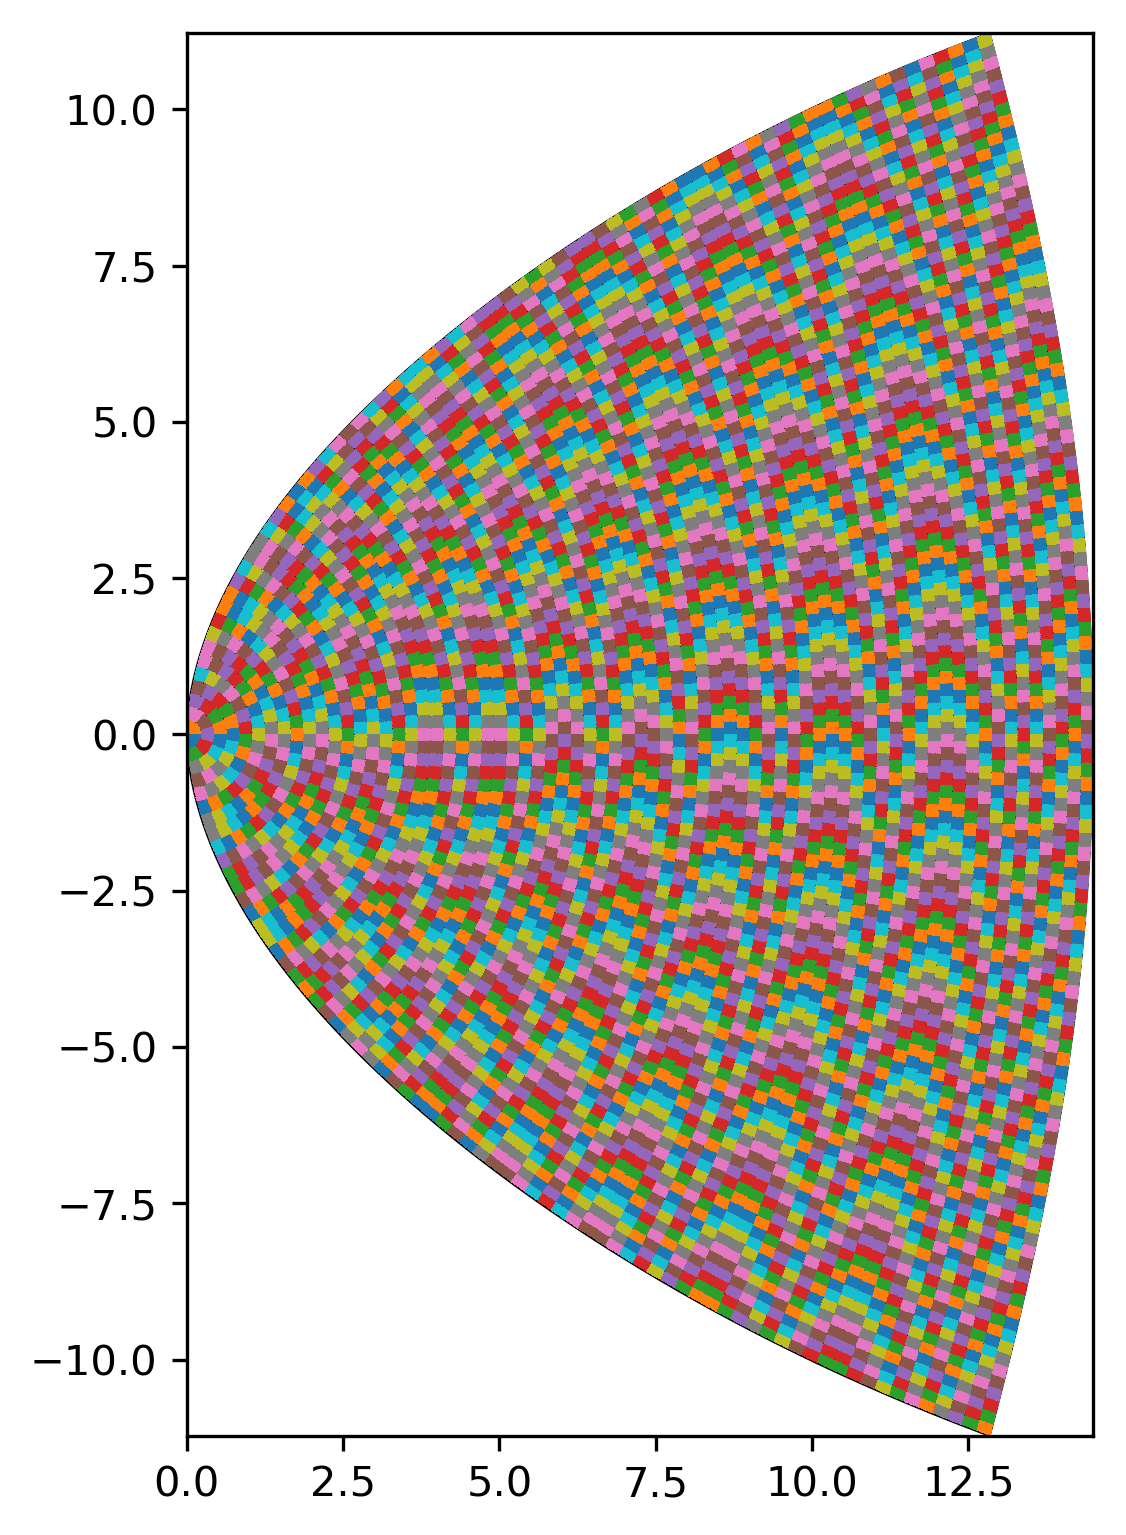

In [10]:
fig, pos = plot_patch(a,b,k,ecc,block_area_L4Cbeta,nblock_L4Cbeta,ax=None,skip=602,s1=0.76,s2=0.1821,ret_fig=True,blockSize=1024)
#fig, pos = plot_patch(a,b,k,ecc,L4_area/32,32,ax=None,skip=602,s1=0.76,s2=0.1821,ret_fig=True,blockSize=1024)

In [1]:
fig.savefig('test_density2.png', dpi = 600)
pos.tofile('test_3d_pos.bin')

NameError: name 'fig' is not defined

characteristic length =

In [33]:
cl = np.sqrt(block_area_L4Cbeta) * 1000
display(Latex(f'{cl:.3f} $\mu m$'))

<IPython.core.display.Latex object>

In [35]:
md = np.power(cl*cl*100/1024,1/3)
display(Latex(f'~204x204x100 $\mu m^3$ (1024 neurons) per block, average inter-neuron(soma)-distance = {md:.3f} $\mu m$'))

<IPython.core.display.Latex object>

conduction velocity ~ 1m/s, being unmylineated horizontal connections  
(0.3m/s for L2/3 and upper L4) <i>Girard et al J Neurophysiol 2001</i>  
minmum delay = 0.016 ms, no spike-correction is needed for time step (dt) < minimum delay
100Hz instantaneous firing rate, 1000 connections leads to ~ 1 spike every 0.01ms. 

In [36]:
dt = 1 #ms
nob = 1000/cl
print(nob)

4.902706663509537


dt = 1ms means neurons in the nearest 5~6 blocks needs to be considered for spike correction  
dt = 0.125ms (1/8) suffice for spike correction within block, #ASSUMPTION# nearfield spike correction only (neurons at block boundarys are neglected) spikes send to the other blocks are resolved after the current step.

#dt = 0.125ms is thus limited by the number of threads per block in NVIDIA GPU  
To further increase dt, will need a cross block spike-correction with CPU, or wait for an update from NVIDIA, otherwise results in an extra increase in spike-correction error, maybe tolerable.

In [37]:
time = 500
dt = 0.0625
batch_time_per_dt = 500e-6 #sec
nstep = time//dt
blocks = 10240
resident_blocks = 8
time_cost = np.int(blocks/resident_blocks) * batch_time_per_dt * nstep
print('simulate for', time ,'ms with dt =', dt, 'ms cost', time_cost/3600,'h')

simulate for 500 ms with dt = 0.0625 ms cost 1.4222222222222223 h


In [38]:
import sobol_seq as ss

In [41]:
pos = np.fromfile('server_data/test_3d_pos.bin')

In [44]:
pos = np.reshape(pos,(3,nblock_L4Cbeta,blockSize))

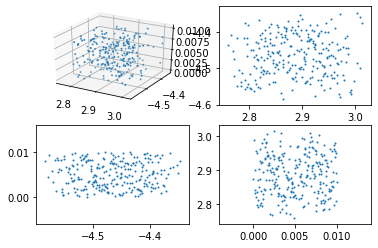

In [45]:
a = pos[:,1023,:].T
from mpl_toolkits.mplot3d import Axes3D
p0 = 768
p1 = 1024
fig = plt.figure('x')
ax = fig.add_subplot(221, projection='3d')
ax.scatter(a[p0:p1,0],a[p0:p1,1],a[p0:p1,2],s=1,zdir='z')
ax = fig.add_subplot(222)
ax.scatter(a[p0:p1,0],a[p0:p1,1], s=1)
ax = fig.add_subplot(223)
ax.scatter(a[p0:p1,1],a[p0:p1,2], s=1)
ax = fig.add_subplot(224)
ax.scatter(a[p0:p1,2],a[p0:p1,0], s=1)

In [46]:
def area(raxn, rden, d):
    area = np.zeros(d.size)
    minr = max(raxn,rden) - min(raxn,rden)
    maxr = max(raxn,rden) + min(raxn,rden)
    area[d <= minr] = np.power(min(raxn,rden),2)*np.pi
    mid_pick = np.logical_and(minr < d, d < maxr)
    d_mid = d[mid_pick]
    cos_theta_axn = (raxn*raxn + d_mid*d_mid - rden*rden)/(2*raxn*d_mid)
    cos_theta_den = (rden*rden + d_mid*d_mid - raxn*raxn)/(2*rden*d_mid)
    seg_axn = np.arccos(cos_theta_axn)*raxn*raxn
    seg_den = np.arccos(cos_theta_den)*rden*rden

    chord_axn = np.sqrt(raxn*raxn - np.power(cos_theta_axn*raxn,2)) * raxn * cos_theta_axn
    chord_den = np.sqrt(rden*rden - np.power(cos_theta_den*rden,2)) * rden * cos_theta_den
    area[mid_pick] = seg_axn+seg_den-chord_axn-chord_den
    assert(np.sum(area<0) == 0)
    return area

def base(raxn, rden, d):
    #subr = d-raxn
    #subr[subr<0] = 0
    #supr = d+raxn
    #supr[supr>rden] = rden
    #base = np.pi*(np.power(supr,2) - np.power(subr,2))
    base = np.pi*(np.power(raxn,2))
    return base

(12.5, 150.0)

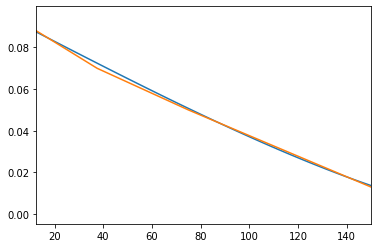

In [47]:
raxn = 100 #um
rden = 100
nd = 100
dd = (raxn+rden)/nd
dee = np.linspace(0,raxn+rden-dd,nd-1)

fig = plt.figure('prob')
ax = fig.add_subplot(111)
ratio = 0.095
ax.plot(dee,  area(raxn,rden,dee)/base(raxn,rden,dee)*ratio)
x = np.array([12.5, 37.5, 75, 150])
y = np.array([8.8, 7.0, 5.0, 1.3])/100
ax.plot(x,y)
ax.set_xlim(x[0],x[-1])

(12.5, 75)

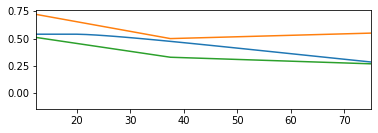

In [48]:
raxn = 100
rden = 80
nd = 100
dd = (raxn+rden)/nd
dii = np.linspace(0, raxn+rden-dd,nd-1)
fig = plt.figure('prob')
ax = fig.add_subplot(211)
y = area(raxn,rden,dii)/base(raxn,rden,dii)
baseline = -0.1
ratio = 1
ax.plot(dii,y*ratio+baseline)
x = [12.5, 37.5, 75]
y = [0.72, 0.50, 0.55]
yr = [0.51, 0.33, 0.27]
ax.plot(x,y)
ax.plot(x,yr)
ax.set_xlim(x[0],x[-1])

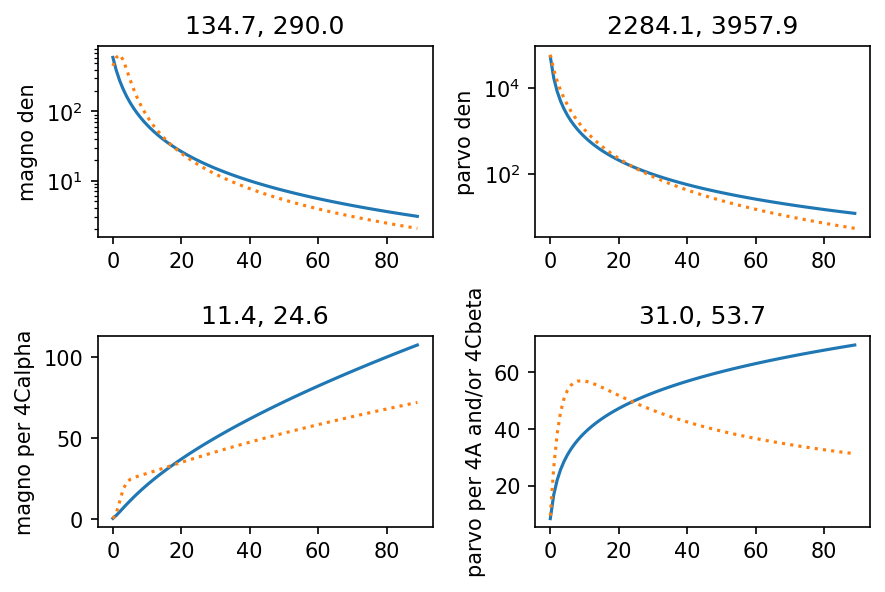

In [49]:
#Connelly-Van_Essen-1984 
Ap = 8.37
Bp = 1.28
Cp = -1.96
parvo_den = lambda E: Ap*(E+Bp)**Cp*10000 # cells/deg^2
Am = 3.52
Bm = 3.1
Cm = -1.56
magno_den = lambda E: Am*(E+Bm)**Cm*1000# cells/deg^2
deg = 5
#consistent Maplpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798)
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012)
fig = plt.figure('lgn cell areal mf', dpi=150)
ax = fig.add_subplot(221)
ecc = np.arange(0,90)
ax.plot(ecc, magno_den(ecc))
ax.plot(ecc, magno_den_alt(ecc),':')
ax.set_title(f'{magno_den(deg):.1f}, {magno_den_alt(deg):.1f}')
ax.set_ylabel('magno den')
ax.set_yscale('log')
ax = fig.add_subplot(222)
ax.plot(ecc, parvo_den(ecc))
ax.plot(ecc, parvo_den_alt(ecc),':')
ax.set_yscale('log')
ax.set_title(f'{parvo_den(deg):.1f}, {parvo_den_alt(deg):.1f}')
ax.set_ylabel('parvo den') 
est_4Cbeta_over_4A = 0.6
magno_spread = 0.5 # micron (mean)
parvo_spread = 0.2 # micron (upper limit)
surface_den_L4Calpha = 17300
magno_spread_reach_max = surface_den_L4Calpha*magno_spread**2
parvo_spread_reach_max = surface_den_L4Cbeta*parvo_spread**2
ax = fig.add_subplot(223)
ax.plot(ecc, magno_den(ecc)/darea(ecc)*magno_spread**2)
ax.plot(ecc, magno_den_alt(ecc)/darea(ecc)*magno_spread**2, ':')
ax.set_ylabel('magno per 4Calpha')
ax.set_title(f'{magno_den(deg)/darea(deg)*magno_spread**2:.1f}, {magno_den_alt(deg)/darea(deg)*magno_spread**2:.1f}')
ax = fig.add_subplot(224)
ax.plot(ecc, parvo_den(ecc)/darea(ecc)*parvo_spread**2)
ax.plot(ecc, parvo_den_alt(ecc)/darea(ecc)*parvo_spread**2, ':')
ax.set_ylabel('parvo per 4A and/or 4Cbeta')
ax.set_title(f'{parvo_den(deg)/darea(deg)*parvo_spread**2:.1f}, {parvo_den_alt(deg)/darea(deg)*parvo_spread**2:.1f}')
plt.tight_layout()

In [50]:
fig.savefig('upper_limit_of_nLGN_per_V1.png')

In [51]:
deg = 5
p_den = lambda E: 110000*(E+1.28)**(-1.96) #cell/deg^2
m_den = lambda E: 4600*(E+3.12)**(-1.56) #cell/deg^2
print(p_den(deg),m_den(deg))
areal_cmf = lambda E: 12.2**2*(E+0.94)**(-2.0) # mm^2/deg^2
print(areal_cmf(deg))
parvo_per_p = p_den(deg)/areal_cmf(deg)
print(f'{parvo_per_p:.1f} P cells/mm^2 to 4Cbeta + 4A')
magno_per_m = m_den(deg)/areal_cmf(deg)
print(f'{magno_per_m:.1f} M cells/mm^2 to 4Calpha')

3001.8693283061225 175.32765576316365
4.218390413676609
711.6 P cells/mm^2 to 4Cbeta + 4A
41.6 M cells/mm^2 to 4Calpha


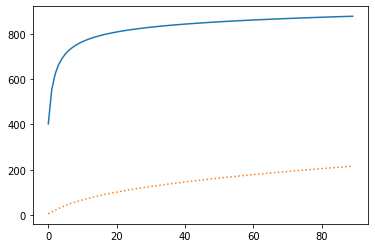

In [52]:
fig = plt.figure('Schein')
ax = fig.add_subplot(111)
ax.plot(ecc, p_den(ecc)/areal_cmf(ecc))
ax.plot(ecc, m_den(ecc)/areal_cmf(ecc),':')